# Importing libraries + Drive connection

In [1]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import sklearn.metrics as sklm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
from dgl.nn import HeteroLinear, HeteroGraphConv, SAGEConv, GATConv, GraphConv, EdgeConv, GINConv
import dgl.function as fn
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Execute this cell only if you want to synchronise Google Drive. Otherwise, enter the path to your file below.
# try:
#     from google.colab import drive
#     drive.mount('/content/drive', force_remount=True)
#     COLAB = True
#     print('Note: using Google CoLab')
#     path_files = '/content/drive/Othercomputers/Mon ordinateur portable/CS/SM11/MLNS/'
# except:
#     print('Note: not using Google CoLab')
#     COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
path_files = '/content/' # Enter the path to your files

# Loading JSON files + quick overview

In [4]:
# Load the Yelp dataset
review_df = pd.read_json(path_files + 'yelp_academic_dataset_review.json', lines=True, nrows=200000)
usecols=['review_id', 'user_id', 'business_id', 'stars']
review_df = review_df[usecols][review_df['stars']>=3]

business_df = pd.read_json(path_files + 'yelp_academic_dataset_business.json', lines=True)
user_df = pd.read_json(path_files + 'yelp_academic_dataset_user.json', lines=True, nrows=100000)

In [5]:
# Find the unique business and user IDs in the review dataframe
review_business_ids = review_df['business_id'].unique()
review_user_ids = review_df['user_id'].unique()

# Filter the business and user dataframes to only include those mentioned in at least one review
business_df_simple = business_df[['business_id', 'categories']]
filtered_business_df = business_df_simple[business_df_simple['business_id'].isin(review_business_ids)].drop_duplicates()
del business_df, business_df_simple
user_df_simple = user_df[['user_id', 'review_count', 'useful', 'funny', 'cool', 'fans']]
filtered_user_df = user_df_simple[user_df_simple['user_id'].isin(review_user_ids)].drop_duplicates()
del user_df_simple, user_df

# Join the review dataframe with the filtered business and user dataframes
merged_review_df = pd.merge(review_df, filtered_business_df, on='business_id')
del review_df
merged_review_df = pd.merge(merged_review_df, filtered_user_df, on='user_id')

# Drop any duplicates
filtered_review_df = merged_review_df.drop_duplicates()[usecols]
del merged_review_df

In [6]:
print(f'----- Businesses df -----\nDim: {filtered_business_df.shape}\n\nGeneric information:')
filtered_business_df.info()
print('\n\n5 first lines')
filtered_business_df.head(5)

----- Businesses df -----
Dim: (10743, 2)

Generic information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10743 entries, 0 to 15033
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10743 non-null  object
 1   categories   10741 non-null  object
dtypes: object(2)
memory usage: 251.8+ KB


5 first lines


,business_id,categories
0,Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
5,CF33F8-E6oudUQ46HnavjQ,"Burgers, Fast Food, Sandwiches, Food, Ice Crea..."


In [7]:
print(f'----- Users df -----\nDim: {filtered_user_df.shape}\n\nGeneric information:')
filtered_user_df.info()
print('\n\n5 first lines')
filtered_user_df.head(5)

----- Users df -----
Dim: (63846, 6)

Generic information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63846 entries, 1 to 99998
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       63846 non-null  object
 1   review_count  63846 non-null  int64 
 2   useful        63846 non-null  int64 
 3   funny         63846 non-null  int64 
 4   cool          63846 non-null  int64 
 5   fans          63846 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 3.4+ MB


5 first lines


,user_id,review_count,useful,funny,cool,fans
1,j14WgRoU_-2ZE1aw1dXrJg,4333,43091,13066,27281,3138
2,2WnXYQFK0hXEoTxPtV2zvg,665,2086,1010,1003,52
5,q_QQ5kBBwlCcbL1s4NVK3g,1221,14953,9940,11211,1357
8,lO1iq-f75hnPNZkTy3Zerg,40,109,40,46,7
9,AUi8MPWJ0mLkMfwbui27lg,109,154,20,23,4


In [8]:
print(f'----- Reviews df -----\nDim: {filtered_review_df.shape}\n\nGeneric information:')
filtered_review_df.info()
print('\n\n5 first lines')
filtered_review_df.head(5)

----- Reviews df -----
Dim: (99314, 4)

Generic information:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99314 entries, 0 to 99313
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    99314 non-null  object
 1   user_id      99314 non-null  object
 2   business_id  99314 non-null  object
 3   stars        99314 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.8+ MB


5 first lines


,review_id,user_id,business_id,stars
0,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4
1,Z7cVdrfk3a7nt5IMYdCsFg,ejFxLGqQcWNLdNByJlIhnQ,-7GDqSUaXrpC8Ql7nDBxWA,4
2,7iReVDHvucme_cHIHYqmvg,ejFxLGqQcWNLdNByJlIhnQ,0mijbNf-7wiKJ9xto1pAyg,5
3,WqgTKVqWVHDHjnjEsBvUgg,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3
4,uyS0ysaMd4mzw5rNYbgcjA,ql0XsKTjM7VeBAUqbphQDw,XQfwVwDr-v0ZS3_CbbE5Xw,3


# Features selection and ID mapping

In [9]:
# Split categories and convert into indicator variables
categories = filtered_business_df['categories'].str.get_dummies(',')
print(f'There are {len(list(categories.columns))} different business categories.')

# Use categories as business input features and create a torch tensor
business_feat = torch.from_numpy(categories.values).to(torch.float)
print(f'Business feature tensor shape: {business_feat.shape}')

# Create a torch user tensor with the selected input features
user_feat = torch.from_numpy(filtered_user_df[['review_count', 'useful', 'funny', 'cool', 'fans']].values).to(torch.float)
print(f'User feature tensor shape: {user_feat.shape}')

There are 1662 different business categories.
Business feature tensor shape: torch.Size([10743, 1662])
User feature tensor shape: torch.Size([63846, 5])


In [10]:
# Create a mapping from unique user indices to range [0, num_user_nodes)
unique_user_id = filtered_review_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print('Mapping of user IDs to consecutive values:\n==========================================')
print(unique_user_id.head())
print()

# Create a mapping from unique business indices to range [0, num_business_nodes)
unique_business_id = filtered_review_df['business_id'].unique()
unique_business_id = pd.DataFrame(data={
    'businessId': unique_business_id,
    'mappedID': pd.RangeIndex(len(unique_business_id)),
})
print('\nMapping of business IDs to consecutive values:\n==============================================')
print(unique_business_id.head())

# Perform merge to obtain the edges from users and businesses
ratings_user_id = pd.merge(filtered_review_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_business_id = pd.merge(filtered_review_df['business_id'], unique_business_id,
                            left_on='business_id', right_on='businessId', how='left')
ratings_business_id = torch.from_numpy(ratings_business_id['mappedID'].values)

edge_index_user_to_business = torch.stack([ratings_user_id, ratings_business_id], dim=0)

print('\nFinal edge indices pointing from users to businesses:\n=====================================================')
print(edge_index_user_to_business)

print('\nChecking the mapping for user 0:\n================================')
filtered_review_df[filtered_review_df['user_id']==unique_user_id['userId'][0]]

Mapping of user IDs to consecutive values:
                   userId  mappedID
0  ejFxLGqQcWNLdNByJlIhnQ         0
1  f7xa0p_1V9lx53iIGN5Sug         1
2  ql0XsKTjM7VeBAUqbphQDw         2
3  j61H-0Coj6TIDqB7axK6lw         3
4  qdneUwCll9ADHOp7i3wq3Q         4


Mapping of business IDs to consecutive values:
               businessId  mappedID
0  XQfwVwDr-v0ZS3_CbbE5Xw         0
1  -7GDqSUaXrpC8Ql7nDBxWA         1
2  0mijbNf-7wiKJ9xto1pAyg         2
3  cXSyVvOr9YRN9diDkaWs0Q         3
4  oYzq49fG7jokPLQ38bFMOw         4

Final edge indices pointing from users to businesses:
tensor([[    0,     0,     0,  ..., 63843, 63844, 63845],
        [    0,     1,     2,  ...,  9344,  9345,  9346]])

Checking the mapping for user 0:


,review_id,user_id,business_id,stars
0,S6pQZQocMB1WHMjTRbt77A,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4
1,Z7cVdrfk3a7nt5IMYdCsFg,ejFxLGqQcWNLdNByJlIhnQ,-7GDqSUaXrpC8Ql7nDBxWA,4
2,7iReVDHvucme_cHIHYqmvg,ejFxLGqQcWNLdNByJlIhnQ,0mijbNf-7wiKJ9xto1pAyg,5


# DGL Heterograph

In [11]:
user_node_ids = torch.arange(len(filtered_user_df))
business_node_ids = torch.arange(len(filtered_business_df))

# Create a graph with two node types, 'user' and 'business'
g = dgl.heterograph({
    ('user', 'reviews', 'business'): (edge_index_user_to_business[0], edge_index_user_to_business[1]),
    ('business', 'reviewed-by', 'user'): (edge_index_user_to_business[1], edge_index_user_to_business[0])},
    num_nodes_dict={'user': len(filtered_user_df), 'business': len(filtered_business_df)})

# Assign node features and IDs
g.nodes['business'].data['feature'] = business_feat
g.nodes['business'].data['node_id'] = business_node_ids

g.nodes['user'].data['feature'] = user_feat
g.nodes['user'].data['node_id'] = user_node_ids

num_nodes = g.num_nodes()
num_edges = g.num_edges()

# Print the graph summary
print('Quick graph overview:\n=====================')
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}\n')
print(g)

Quick graph overview:
Number of nodes: 74589
Number of edges: 198628

Graph(num_nodes={'business': 10743, 'user': 63846},
      num_edges={('business', 'reviewed-by', 'user'): 99314, ('user', 'reviews', 'business'): 99314},
      metagraph=[('business', 'user', 'reviewed-by'), ('user', 'business', 'reviews')])


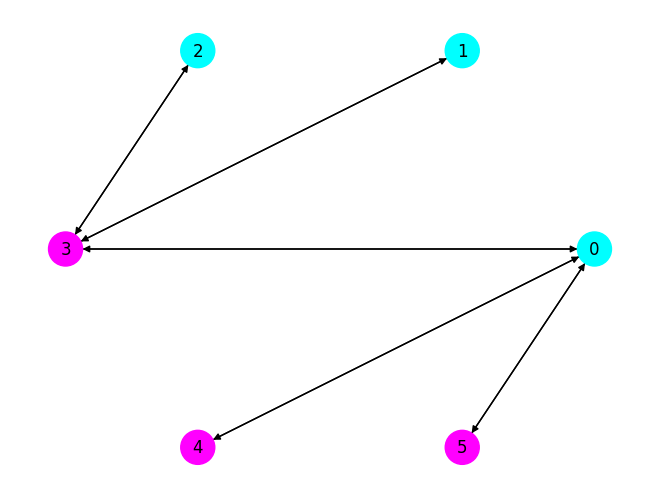

In [31]:
# Display a subset of the graph
sub_g = dgl.edge_subgraph(g, {('business', 'reviewed-by', 'user'): [0, 1, 2, 3, 4], ('user', 'reviews', 'business'): [0, 1, 2, 3, 4]})
homo_g = dgl.to_homogeneous(sub_g)
nx_g = dgl.to_networkx(homo_g, node_attrs=['_TYPE'], edge_attrs=['_TYPE'])

plt.figure()
pos = nx.circular_layout(nx_g)
node_color = homo_g.ndata['_TYPE']
nx.draw(nx_g, pos, with_labels = True, node_color=node_color, node_size=600, cmap=plt.cm.cool)
plt.show()

# GNN architectures

In [ ]:
class RGCN(nn.Module):
    def __init__(self, in_feats_user, in_feats_business, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = HeteroGraphConv({rel: GraphConv(in_feats_user if rel == 'reviews' else in_feats_business, hid_feats, activation=F.relu) for rel in rel_names}, aggregate='sum')
        self.conv2 = HeteroGraphConv({rel: GraphConv(hid_feats, hid_feats, activation=F.relu) for rel in rel_names}, aggregate='sum')
        self.conv3 = HeteroGraphConv({rel: GraphConv(hid_feats, out_feats, activation=F.relu) for rel in rel_names}, aggregate='sum')

    def forward(self, graph, neg_graph, inputs, etype):
        # Inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        h = self.conv3(graph, h)
        return h

In [ ]:
class RGraphSage(nn.Module):
    def __init__(self, in_feats_user, in_feats_business, hid_feats, out_feats, rel_names):
        super().__init__()

        self.lin = HeteroLinear({'user': in_feats_user, 'business': in_feats_business}, hid_feats)
        self.conv1 = HeteroGraphConv({rel: SAGEConv(hid_feats, hid_feats, aggregator_type='mean', activation=F.relu) for rel in rel_names}, aggregate='sum')
        self.conv2 = HeteroGraphConv({rel: SAGEConv(hid_feats, out_feats, aggregator_type='mean', activation=F.relu) for rel in rel_names}, aggregate='sum')

    def forward(self, graph, neg_graph, inputs, etype):
        h = self.lin(inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv1(graph, h)
        h = self.conv2(graph, h)
        return h

In [ ]:
class REdgeConv(nn.Module):
    def __init__(self, in_feats_user, in_feats_business, hid_feats, out_feats, rel_names):
        super().__init__()

        self.lin = HeteroLinear({'user': in_feats_user, 'business': in_feats_business}, hid_feats)
        self.conv1 = HeteroGraphConv({rel: EdgeConv(hid_feats, hid_feats) for rel in rel_names}, aggregate='sum')
        self.conv2 = HeteroGraphConv({rel: EdgeConv(hid_feats, out_feats) for rel in rel_names}, aggregate='sum')

    def forward(self, graph, neg_graph, inputs, etype):
        h = self.lin(inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv1(graph, h)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        h = {k: F.relu(v) for k, v in h.items()}
        return h

In [ ]:
class RGINConv(nn.Module):
    def __init__(self, in_feats_user, in_feats_business, hid_feats, out_feats, rel_names):
        super().__init__()

        self.lin = HeteroLinear({'user': in_feats_user, 'business': in_feats_business}, hid_feats)
        self.conv1 = HeteroGraphConv({rel: GINConv(torch.nn.Linear(hid_feats, hid_feats), activation=F.relu) for rel in rel_names}, aggregate='sum')
        self.conv2 = HeteroGraphConv({rel: GINConv(torch.nn.Linear(hid_feats, out_feats), activation=F.relu) for rel in rel_names}, aggregate='sum')

    def forward(self, graph, neg_graph, inputs, etype):
        h = self.lin(inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv1(graph, h)
        h = self.conv2(graph, h)
        return h

In [ ]:
class RGAT(nn.Module):
    def __init__(self, in_feats_user, in_feats_business, hid_feats, out_feats, rel_names, heads=3):
        super().__init__()

        self.lin = HeteroLinear({'user': in_feats_user, 'business': in_feats_business}, hid_feats)
        self.conv1 = HeteroGraphConv({rel: GATConv((hid_feats, hid_feats), hid_feats, num_heads=heads, activation=F.relu) for rel in rel_names}, aggregate='sum')
        # self.conv2 = HeteroGraphConv({rel: GATConv((hid_feats, hid_feats), hid_feats, num_heads=heads, activation=F.relu, feat_drop=0.2, attn_drop=0.2) for rel in rel_names}, aggregate='sum')
        self.conv3 = HeteroGraphConv({rel: GATConv((hid_feats, hid_feats), out_feats, num_heads=1, activation=F.relu) for rel in rel_names}, aggregate='sum')

    def forward(self, graph, neg_graph, inputs, etype):
        h = self.lin(inputs)
        h = self.conv1(graph, h)
        # Averaging the attention heads
        h = {k: torch.mean(v, 1) for k, v in h.items()}
        # h = self.conv2(graph, h)
        # h = {k: torch.mean(v, 1) for k, v in h.items()}
        h = self.conv3(graph, h)
        h = {k: torch.squeeze(v) for k, v in h.items()}
        return h

In [ ]:
class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, nodes_embeddings, etype):
        with graph.local_scope():
            graph.ndata['gnn_embeddings'] = nodes_embeddings
            graph.apply_edges(fn.u_dot_v('gnn_embeddings', 'gnn_embeddings', 'score'), etype=etype)
            return graph.edges[etype].data['score']

class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_features=5):
        super().__init__()
        self.W = nn.Linear(in_features * 2, 1)

    def apply_edges(self, edges):
        h_u = edges.src['gnn_embeddings']
        h_v = edges.dst['gnn_embeddings']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, nodes_embeddings, etype):
        with graph.local_scope():
            graph.ndata['gnn_embeddings'] = nodes_embeddings
            graph.apply_edges(self.apply_edges, etype=etype)
            return graph.edges[etype].data['score']

# Negative sampling and train-test split

In [ ]:
def construct_negative_graph(graph, neg_edge_ratio, etypes_set):
    '''
    Constructs a negative graph by randomly sampling k negative edges for each positive edge of given types.

    Args:
    graph (dgl.DGLHeteroGraph): The original graph.
    neg_edge_ratio (int): The number of negative edges to sample per positive edge.
    etypes_set (set): A set of edge types for which to construct negative edges.

    Returns:
    A new DGLHeteroGraph object representing the negative graph.
    '''
    data = {}
    for etype in etypes_set:
        utype, _, vtype = etype
        src, dst = graph.edges(etype=etype)
        neg_src = src.repeat_interleave(neg_edge_ratio)
        neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src)*neg_edge_ratio, ))
        data[etype] = (neg_src, neg_dst)
    return dgl.heterograph(data, num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

In [ ]:
# Split edge set for training and testing
eids = np.arange(g.number_of_edges(etype='reviews'))
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)

train_graph = dgl.remove_edges(g, eids=eids[:test_size], etype='reviews')
train_graph = dgl.remove_edges(train_graph, eids=eids[:test_size], etype='reviewed-by')
print('Quick graph overview:\n=====================')
print(train_graph)

Quick graph overview:
Graph(num_nodes={'business': 10743, 'user': 63846},
      num_edges={('business', 'reviewed-by', 'user'): 89383, ('user', 'reviews', 'business'): 89383},
      metagraph=[('business', 'user', 'reviewed-by'), ('user', 'business', 'reviews')])


In [ ]:
test_graph = dgl.remove_edges(g, eids=eids[test_size:], etype='reviews')
test_graph = dgl.remove_edges(test_graph, eids=eids[test_size:], etype='reviewed-by')
print('Quick graph overview:\n=====================')
print(test_graph)

Quick graph overview:
Graph(num_nodes={'business': 10743, 'user': 63846},
      num_edges={('business', 'reviewed-by', 'user'): 9931, ('user', 'reviews', 'business'): 9931},
      metagraph=[('business', 'user', 'reviewed-by'), ('user', 'business', 'reviews')])


# Metrics and training loop

In [ ]:
def compute_margin_loss(pos_score, neg_score):
    '''
    Computes the margin loss given positive and negative scores.
    '''
    n_edges = pos_score.shape[0]
    return (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()

def compute_auc(pos_score, neg_score):
    '''
    Computes the Area Under the ROC Curve (AUC) given positive and negative scores.
    '''
    scores = torch.cat([pos_score, neg_score]).numpy()
    scores_proba = 1 / (1 + np.exp(-scores))
    edges_true = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    # Compute optimal threshold
    fpr, tpr, thresholds = sklm.roc_curve(edges_true, scores_proba) 
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    edges_pred = np.where(scores_proba >= optimal_threshold, 1, 0)
    
    return roc_auc_score(edges_true, scores), edges_true, edges_pred

def compute_bce_loss(pos_score, neg_score):
    '''
    Computes the Binary Cross Entropy (BCE) loss given positive and negative scores.
    '''
    scores = torch.cat([pos_score.flatten(), neg_score.flatten()])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

In [ ]:
def train_hetero_gnn(graph, etypes_set, optimizer, node_features, neg_edge_ratio, gnn_embeddings_model, dot_predictor):
    # Construction of negative graph
    negative_graph = construct_negative_graph(graph, neg_edge_ratio, etypes_set)

    # Forward
    etype_to_predict = ('user', 'reviews', 'business')
    embeddings = gnn_embeddings_model(graph, negative_graph, node_features, etype_to_predict)
    pos_score = dot_predictor(graph, embeddings, etype_to_predict)
    neg_score = dot_predictor(negative_graph, embeddings, etype_to_predict)
    loss = compute_bce_loss(pos_score, neg_score)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, embeddings, etype_to_predict

In [ ]:
hetero_graph = train_graph
hid_size, embd_size = 20, 5

models = [
    (RGCN(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGCN'),
    (RGraphSage(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGraphSage'),
    (RGAT(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGAT'),
    (REdgeConv(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'REdgeConv'),
    (RGINConv(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGINConv')
]
predictor = HeteroMLPPredictor() # HeteroDotProductPredictor()
node_features = {
    'user': hetero_graph.nodes['user'].data['feature'],
    'business': hetero_graph.nodes['business'].data['feature']
    }
etypes_set = set([('user', 'reviews', 'business'), ('business', 'reviewed-by', 'user')])
neg_edge_ratio=5

for model_init, name_model in models:
    print(f'\n{name_model}\n=====\n')
    acc_list = []
    rec_list = []
    f1_list = []
    prec_list = []
    auc_list = []
    for iter in range(15):
        model = model_init
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), predictor.parameters()), lr=0.01)
        start = time.time()
        for epoch in range(200):
            loss, embeddings, etype_to_predict = train_hetero_gnn(train_graph, etypes_set, optimizer, node_features, neg_edge_ratio, gnn_embeddings_model=model, dot_predictor=predictor)
            if (epoch+1) % 100 == 0:
                elapsed_time = np.round(time.time()-start, 2)
                print(f'----- Epoch {(epoch+1)} | {elapsed_time}sec elapsed -----\nTraining loss: {np.round(loss.item(), 5)}')
                with torch.no_grad():
                    model.eval()
                    neg_test_graph = construct_negative_graph(test_graph, neg_edge_ratio, etypes_set)
                    pos_score = predictor(test_graph, embeddings, etype_to_predict)
                    neg_score = predictor(neg_test_graph, embeddings, etype_to_predict)
                    auc_test, edges_true, edges_pred = compute_auc(pos_score, neg_score)
                    print(sklm.confusion_matrix(edges_true, edges_pred).ravel()) # TN, FP, FN, TP
                    accuracy_gnn = sklm.accuracy_score(edges_true, edges_pred)
                    f1_gnn = sklm.f1_score(edges_true, edges_pred)
                    precision_gnn = sklm.precision_score(edges_true, edges_pred)
                    recall_gnn = sklm.recall_score(edges_true, edges_pred)
                    print(f'''Accuracy on test set: {round(accuracy_gnn, 5)}
Precision on test set: {round(precision_gnn, 5)}
Recall on test set: {round(recall_gnn, 5)}
F1-Score on test set: {round(f1_gnn, 5)}
AUC on test set: {np.round(auc_test, 5)}\n''')
                    
        acc_list.append(accuracy_gnn)
        rec_list.append(recall_gnn)
        f1_list.append(f1_gnn)
        prec_list.append(precision_gnn)
        auc_list.append(auc_test)
    print(f'''\n\n++++++++++\nResults for {name_model}:
Accuracy: {np.mean(np.array(acc_list))} +- {np.std(np.array(acc_list))}
Precision: {np.mean(np.array(prec_list))} +- {np.std(np.array(prec_list))}
Recall: {np.mean(np.array(rec_list))} +- {np.std(np.array(rec_list))}
F1-Score: {np.mean(np.array(f1_list))} +- {np.std(np.array(f1_list))}
AUC: {np.mean(np.array(auc_list))} +- {np.std(np.array(auc_list))}
++++++++++\n\n''')



REdgeConv
=====

----- Epoch 100 | 46.55sec elapsed -----
Training loss: 0.41914
[28525 21130  2068  7863]
Accuracy on test set: 0.61068
Precision on test set: 0.2712
Recall on test set: 0.79176
F1-Score on test set: 0.40402
AUC on test set: 0.69428

----- Epoch 200 | 90.83sec elapsed -----
Training loss: 0.40364
[28204 21451  1739  8192]
Accuracy on test set: 0.61081
Precision on test set: 0.27636
Recall on test set: 0.82489
F1-Score on test set: 0.41401
AUC on test set: 0.71876

----- Epoch 100 | 44.34sec elapsed -----
Training loss: 0.40316
[29290 20365  1906  8025]
Accuracy on test set: 0.62624
Precision on test set: 0.28267
Recall on test set: 0.80808
F1-Score on test set: 0.41883
AUC on test set: 0.71919

----- Epoch 200 | 88.64sec elapsed -----
Training loss: 0.40642
[27369 22286  1654  8277]
Accuracy on test set: 0.59823
Precision on test set: 0.27082
Recall on test set: 0.83345
F1-Score on test set: 0.4088
AUC on test set: 0.70692

----- Epoch 100 | 46.68sec elapsed -----
Tra

In [ ]:
models = [
    (RGCN(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGCN'),
    (RGraphSage(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGraphSage'),
    (RGAT(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGAT'),
    (REdgeConv(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'REdgeConv'),
    (RGINConv(user_feat.shape[1], business_feat.shape[1], hid_size, embd_size, hetero_graph.etypes), 'RGINConv')
]
for model, name in models:
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters for {name}: {num_params}")

Number of parameters for RGCN: 34430
Number of parameters for RGraphSage: 35430
Number of parameters for RGAT: 38970
Number of parameters for REdgeConv: 35480
Number of parameters for RGINConv: 34430
